In [43]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Preprocessing data

In [44]:
seed = 42
# Reading data 
data = pd.read_csv("./breast-cancer.txt", sep=",")
print(data.head())

# Dropping missing or non numeric values
nan_rows = data.isna().any(axis=1)
print("Count of missing data: " + str(nan_rows.value_counts()))

# Identifying and removing non numeric data
print(data.info())
data = data.drop("bare_nuclei", axis=1)

# Drop id column
data = data.drop("id", axis=1)

# Create feature and label arrays
y = data["class"]
X = data.drop("class", axis=1)

# Scaling feature matrix
sc = StandardScaler()
X = sc.fit_transform(X)

# Transforming feature vector into bool
y = y.replace({2:False, 4:True})

# Dividing data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        id  clump_thickness  uniform_cell_size  uniform_cell_shape  \
0  1000025                5                  1                   1   
1  1002945                5                  4                   4   
2  1015425                3                  1                   1   
3  1016277                6                  8                   8   
4  1017023                4                  1                   1   

   marginal_adhesion  single_epi_cell_size bare_nuclei  bland_chromation  \
0                  1                     2           1                 3   
1                  5                     7          10                 3   
2                  1                     2           2                 3   
3                  1                     3           4                 3   
4                  3                     2           1                 3   

   normal_nucleoli  mitoses  class  
0                1        1      2  
1                2        1      2  
2          

# Creation of Neuronal Network

In [45]:
def get_basic_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_basic_model()
model.fit(X_train, y_train, epochs=15, batch_size=16)


Epoch 1/15
35/35 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.8676
Epoch 2/15
35/35 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.9320
Epoch 3/15
35/35 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.9392
Epoch 4/15
35/35 [==============================] - 0s 2ms/step - loss: 0.4135 - accuracy: 0.9445
Epoch 5/15
35/35 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.9428
Epoch 6/15
35/35 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.9445
Epoch 7/15
35/35 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.9445
Epoch 8/15
35/35 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.9499
Epoch 9/15
35/35 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9499
Epoch 10/15
35/35 [==============================] - 0s 3ms/step - loss: 0.1769 - accuracy: 0.9481
Epoch 11/15
35/35 [

In [46]:
def to_bool(x):
    if x>=0:
        return True
    return False

predictions = model.predict(X_test)
y_test = y_test.reset_index(drop=True)
predictions = np.apply_along_axis(to_bool,axis=1, arr=predictions)

5/5 [==============================] - 0s 5ms/step


# Confusion Matrix

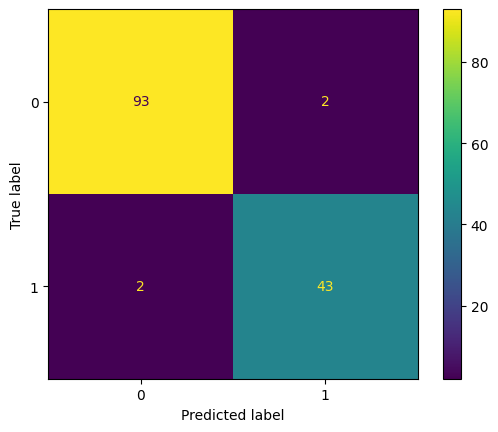

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_ens = confusion_matrix(y_true=y_test, y_pred=predictions)
disp_ens = ConfusionMatrixDisplay(cm_ens)
disp_ens.plot()